In [1]:
import os
import rasterio as rio
import numpy as np
import geopandas as gpd
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from progressbar import ProgressBar

plt.rcParams["figure.figsize"] = (28,10)
plt.ion()

In [122]:
data_dir = 'data_100m'

dem_file            = f'{data_dir}/dem.tif'
slope_file          = f'{data_dir}/slope.tif'
aspect_file         = f'{data_dir}/aspect.tif'
northing_file       = f'{data_dir}/northing.tif'
easting_file        = f'{data_dir}/easting.tif'

urban_distance_file = f'{data_dir}/Urbano.tiff'
roads_distance_file = f'{data_dir}/Strade.tiff'
crops_distance_file = f'{data_dir}/Coltivo.tiff'

vegetation_agg_file = f'{data_dir}/vegetation_agg.tiff'
vegetation_file     = f'{data_dir}/vegetation.tiff'

fires_shp           = 'shapefiles/perimetrazioni_1997_2017.shp'
vegetation_shp      = 'shapefiles/tipiforestali_usosuolo_ctr_fv.shp'
roads_shp      = 'shapefiles/Tratte_stradali.shp'

In [126]:
with rio.open(dem_file) as src:
    print(f'Reading dem file {dem_file}')
    dem = src.read(1)
    dem[dem <= -9999] = np.NaN
_, dx, _, _, _, dy = src.transform.to_gdal()    
bbox = src.bounds

Reading dem file data_100m/dem.tif


## PREPROCESSING

In [5]:
from sklearn import preprocessing
from rasterio import features

from shapely.geometry import Point, GeometryCollection

def extract_coordinates(indices, src):
    indices_t = indices.T[::-1, :]

    coordinates = np.stack(src.transform * indices_t)

    _, dx, _, _, _, dy = src.transform.to_gdal()
    coordinates = coordinates + np.array([[dx, dy]]).T/2

    #points = [Point(*p) for p in coordinates.T]

    return coordinates


def encode_feature(gdf, column):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(gdf[column])
    encoded_column = encoder.transform(gdf[column])
    mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_,))
    return encoded_column, mapping


def rasterize_numerical_feature(gdf, column, reference_file):
    with rio.open(reference_file) as f:
        out = f.read(1)
        out_array = np.empty(out.shape)
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf[column]))

        burned = features.rasterize(shapes=shapes, fill=np.NaN, out=out_array, transform=f.transform)
    #    out.write_band(1, burned)

    return burned

def save_raster_as(array, output_file, reference_file, **kwargs):
    with rio.open(reference_file) as f:
        profile = f.profile
        profile.update(**kwargs)

        with rio.open(output_file, 'w', **profile) as dst:
            dst.write(array.astype(profile['dtype']), 1)
            
def read_tiff(tiff_file):
    with rio.open(tiff_file) as f:
        print(f'Reading file {tiff_file}')        
        data = f.read(1)
    return data

In [6]:
def calculate_box_grid(bbox, dx, dy, box_dim):
    lon_min, lon_max, lon_step = bbox.left   +dx/2 + box_dim/2, bbox.right +dx/2 - box_dim/2, box_dim
    lat_min, lat_max, lat_step = bbox.bottom +dy/2 + box_dim/2, bbox.top   +dy/2 - box_dim/2, box_dim
    return lon_min, lon_max, lon_step, lat_min, lat_max, lat_step


def build_boxes(lon_min, lon_max, lon_step, lat_min, lat_max, lat_step):
    box_lon = np.arange(lon_min, lon_max +lon_step/2, lon_step)
    box_lat = np.arange(lat_min, lat_max +lat_step/2, lat_step)
    box_lons, box_lats = np.meshgrid(box_lon, box_lat)

    return box_lons, box_lats
    
def get_boxes_rc(coordinates, lon_min, lon_step, lat_min, lat_step):
    C = (np.round((coordinates[0, :] - lon_min) / lon_step)).astype('int')
    R = (np.round((coordinates[1, :] - lat_min) / lat_step)).astype('int')
    RC = np.array((R, C))
    return RC

def calculate_box_intersections(selected_features, box_lons, box_lats, RC):
    unique_rc = np.unique(RC, axis=1)

    box_cuts = {}
    bar = ProgressBar()
    for rc in bar(unique_rc.T):
        lon, lat = box_lons[rc[0], rc[1]], box_lats[rc[0], rc[1]]
        box = Point(lon, lat).buffer(box_dim + buffer_dim).envelope
        box_cut = [box.intersection(g) for g in selected_features.geometry]
        box_cuts[(rc[0], rc[1])] = box_cut
    
    return box_cuts

def calculate_distances_on_boxes(coordinates, RC, box_cuts, outside_value=-9999):
    bar = ProgressBar()
    distances = []
    points = []
    for p, rc in bar(zip(coordinates.T, RC.T)):
        point = Point(*p)
        p_distances = [
            point.distance(g) 
            if not g.is_empty 
            else np.NaN 
            for g in box_cuts[(rc[0], rc[1])]
        ] 
        d = np.nanmin(p_distances)
        d = outside_value if d > buffer_dim else d
        distances.append(d)
        points.append(point)
        
    return distances, points

In [7]:
with rio.open(dem_file) as src:
    print(f'Reading dem file {dem_file}')
    dem = src.read(1)
    dem[dem <= -9999] = np.NaN

if not os.path.isfile(slope_file):
    print(f'Creating slope file {slope_file}')
    gdal.DEMProcessing(slope_file, dem_file, 'slope')

    
if not os.path.isfile(northing_file) or not os.path.isfile(easting_file):

    if not os.path.isfile(aspect_file):
        print(f'Creating aspect file {aspect_file}')
        gdal.DEMProcessing(aspect_file, dem_file, 'aspect')

    with rio.open(aspect_file) as f:
        print(f'Calculating northing and easting files')
        print(f'Reading aspect file {aspect_file}')
        aspect = f.read(1)
        aspect[aspect <= -9999] = np.NaN    
        northing = np.cos(aspect * np.pi/180.0)
        easting = np.sin(aspect * np.pi/180.0)

    print(f'Saving northing file {northing_file}')
    save_raster_as(northing, northing_file, aspect_file)
    print(f'Saving easting file {easting_file}')    
    save_raster_as(easting, easting_file, aspect_file)

Reading dem file data_100m/dem.tif


In [7]:
print(f'Reading vegetation shp {vegetation_shp}')
vegetation = gpd.read_file(vegetation_shp)
vegetation['encoded_decodifica'], mapping = encode_feature(vegetation, 'Decodifica')    

if not os.path.isfile(vegetation_agg_file):
    print(f'Rasterizing vegetation')
    vegetation_raster = rasterize_numerical_feature(vegetation, 'encoded_decodifica', dem_file)
    print(f'Writing vegetation_raster file {vegetation_agg_file}')    
    save_raster_as(vegetation_raster, vegetation_file, dem_file)
    

if not os.path.isfile(vegetation_agg_file):
    print(f'Rasterizing vegetation_agg')    
    vegetation_agg_raster = rasterize_numerical_feature(vegetation, 'id_agg_fv', dem_file)
    print(f'Writing vegetation_agg_raster file {vegetation_agg_file}')
    save_raster_as(vegetation_agg_raster, vegetation_agg_file, dem_file)
    
if not os.path.isfile(vegetation_agg_file):
    print(f'Rasterizing vegetation_agg')    
    vegetation_agg_raster = rasterize_numerical_feature(vegetation, 'id_agg_fv', dem_file)
    print(f'Writing vegetation_agg_raster file {vegetation_agg_file}')
    save_raster_as(vegetation_agg_raster, vegetation_agg_file, dem_file)
    

In [127]:
box_dim = 10000.0
buffer_dim = 3000.0

In [11]:
distance_types = 'Coltivo', 'Urbano'

for distance_type in distance_types:
    distance_file = f'{data_dir}/{distance_type}.tiff'

    if not os.path.isfile(distance_file):
        if mask is None:
            vegetation_agg_raster = read_tiff(vegetation_agg_file)
            mask = vegetation_agg_raster >= 20
            indices = np.argwhere(mask)
            coordinates = extract_coordinates(indices, src)
        
        print(f'Calculating distance {distance_type}')        
        selected_features = vegetation.query(f'{distance_type} == 1')

        lon_min, lon_max, lon_step, lat_min, lat_max, lat_step = calculate_box_grid(bbox, dx, dy, box_dim)
        box_lons, box_lats = build_boxes(lon_min, lon_max, lon_step, lat_min, lat_max, lat_step)
        RC = get_boxes_rc(coordinates, lon_min, lon_step, lat_min, lat_step)
        box_cuts = calculate_box_intersections(selected_features, box_lons, box_lats, RC)

        distances, points = calculate_distances_on_boxes(coordinates, RC, box_cuts)

        data = np.empty_like(dem)
        data[mask] = distances
        
        print(f'Writing distance file {distance_file}')
        save_raster_as(data, distance_file, dem_file)

In [125]:
print(f'Reading roads shp {roads_shp}')
roads = gpd.read_file(roads_shp)

In [ ]:
lon_min, lon_max, lon_step, lat_min, lat_max, lat_step = calculate_box_grid(bbox, dx, dy, box_dim)
box_lons, box_lats = build_boxes(lon_min, lon_max, lon_step, lat_min, lat_max, lat_step)
RC = get_boxes_rc(coordinates, lon_min, lon_step, lat_min, lat_step)
box_cuts = calculate_box_intersections(roads, box_lons, box_lats, RC)

distances, points = calculate_distances_on_boxes(coordinates, RC, box_cuts)

roads_distance = np.empty_like(dem)
roads_distance[mask] = roads_distance

print(f'Writing distance file {roads_distance_file}')
save_raster_as(roads_distance, roads_distance_file, dem_file)

100% (93 of 93) |########################| Elapsed Time: 0:03:36 Time:  0:03:36
- |                                           #   | 21301 Elapsed Time: 0:48:19

,ORIG,ORIGINE,TP_TRA,TIPO_TRATT,SED,SEDE,PERCFITTIZ,PERCORSO_F,STAT,STATO,CLTECFUN,CLASS_TECN,SOTTOPASSO,ID_SEDE,CLASS_MAX_,COD_ENTE_G,COD_STRADA,ID,geometry
0,da CTR,2,tratto di strada indifferenziata,1,propria,1,tratto di effettiva percorrenza veicolare,F,In esercizio,1,autostrada,1,F,None,None,None,121,148601,LINESTRING Z (1395231.66999714 4850846.7013805...
1,da CTR,2,tratto di strada indifferenziata,1,"su ponte, viadotto",2,tratto di effettiva percorrenza veicolare,F,In esercizio,1,autostrada,1,F,None,None,None,121,148701,LINESTRING Z (1394958.63999709 4850636.7013803...
2,da CTR,2,tratto di strada indifferenziata,1,propria,1,tratto di effettiva percorrenza veicolare,F,In esercizio,1,autostrada,1,F,None,None,None,121,148801,LINESTRING Z (1405608.84999862 4855309.1013848...
3,da CTR,2,tratto di strada indifferenziata,1,propria,1,tratto di effettiva percorrenza veicolare,F,In esercizio,1,autostrada,1,F,None,None,None,111,148901,LINESTRING Z (1405596.95999862 4855299.0013848...
4,da CTR,2,tratto di strada indifferenziata,1,propria,1,tratto di effettiva percorrenza veicolare,F,In esercizio,1,autostrada,1,F,None,None,None,121,149001,LINESTRING Z (1405715.32999863 4855306.0013848...


## DATA PREPARATION

In [8]:
print(f'Reading northing file {slope_file}')
slope = read_tiff(slope_file)

print(f'Reading northing file {northing_file}')
northing = read_tiff(northing_file)
    
print(f'Reading easting file {easting_file}') 
easting = read_tiff(easting_file)

print(f'Reading vegetation_raster file {vegetation_file}')            
vegetation_raster = read_tiff(vegetation_file)
    
print(f'Reading vegetation_agg_raster file {vegetation_agg_file}')          
vegetation_agg_raster = read_tiff(vegetation_agg_file)

print(f'Reading urban distance file {urban_distance_file}')
urban_distance = read_tiff(urban_distance_file)

print(f'Reading roads distance file {roads_distance_file}')
roads_distance = read_tiff(roads_distance_file)

print(f'Reading roads distance file {crops_distance_file}')
crops_distance = read_tiff(crops_distance_file)

Reading northing file data_100m/slope.tif
Reading file data_100m/slope.tif
Reading northing file data_100m/northing.tif
Reading file data_100m/northing.tif
Reading easting file data_100m/easting.tif
Reading file data_100m/easting.tif
Reading vegetation_raster file data_100m/vegetation.tiff
Reading file data_100m/vegetation.tiff
Reading vegetation_agg_raster file data_100m/vegetation_agg.tiff
Reading file data_100m/vegetation_agg.tiff
Reading urban distance file data_100m/Urbano.tiff
Reading file data_100m/Urbano.tiff
Reading roads distance file data_100m/Strade.tiff
Reading file data_100m/Strade.tiff
Reading roads distance file data_100m/Coltivo.tiff
Reading file data_100m/Coltivo.tiff


In [9]:
print(f'Reading vegetation shp {vegetation_shp}')
vegetation = gpd.read_file(vegetation_shp)
vegetation['encoded_decodifica'], mapping = encode_feature(vegetation, 'Decodifica')

Reading vegetation shp shapefiles/tipiforestali_usosuolo_ctr_fv.shp


In [33]:
# masking vegetation raster excluding non-vegetated areas
mask = (vegetation_agg_raster >= 20) & (dem != -9999) & (slope != -9999) & (northing != -9999) & (easting != -9999)
indeces = np.argwhere(mask)
coordinates = extract_coordinates(indeces, src)
points_geom = [Point(*p) for p in coordinates.T]

points = gpd.GeoDataFrame(pd.DataFrame(indeces, columns=['row', 'col']), geometry=points_geom, crs={'init': 'epsg:3003'})

In [34]:
points_envelopes = points.copy()
points_envelopes.geometry = points.geometry.buffer(dx/2).envelope

In [35]:
print(f'Reading fires shp {fires_shp}')
fires = gpd.read_file(fires_shp)

Reading fires shp shapefiles/perimetrazioni_1997_2017.shp


In [36]:
presence_df = gpd.sjoin(points_envelopes, fires)\
             .loc[:, ('row', 'col', 'data', 'anno', 'stagione', 'area_ha')]

In [37]:
absence_idx = ~points.index.isin(presence_df.index)
absence_df = points.iloc[points.index[absence_idx]]

In [38]:
presence_df.loc[:, 'fire'] = 1
absence_df.loc[:, 'fire'] = 0

dataset = pd.concat((presence_df, absence_df), axis=0)

/Volumes/DATA_ExFAT/datascience/suscettivita-incendi-liguria/.conda/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Volumes/DATA_ExFAT/datascience/suscettivita-incendi-liguria/.conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Volumes/DATA_ExFAT/datascience/suscettivita-incendi-liguria/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting 

In [94]:
data_dict = {
    'dem': dem,
    'slope': slope,
    'north': northing,
    'east': easting,
    'veg': vegetation_raster,
    'veg_agg': vegetation_agg_raster,
    'urban_d': urban_distance,
    'roads_d': roads_distance,
    'crops_d': crops_distance
}

In [95]:
for k, v in data_dict.items():
    dataset[k] = v[dataset.row.values, dataset.col.values]
    
dataset.loc[dataset['north'].isna(), 'north'] = 0
dataset.loc[dataset['east'].isna(), 'east'] = 0
dataset.loc[dataset['roads_d'].isna(), 'roads_d'] = -9999   

In [96]:
dataset.geometry = points.loc[dataset.index].geometry

In [42]:
dataset.to_file(f'{data_dir}/dataset.geojson', driver='GeoJSON')

In [97]:
dataset_csv = dataset.copy()
dataset_csv['x'] = dataset_csv.geometry.x
dataset_csv['y'] = dataset_csv.geometry.y

In [98]:
dataset_csv = dataset_csv.drop('geometry', axis=1)
dataset_csv.to_csv(f'{data_dir}/dataset.csv')

# Random Forest

In [84]:
variables = list(data_dict.keys())
variables.remove('veg_agg')

In [103]:
sample_size = 1
# create a dataset selecting a sample of points from fire points, then the same amount of absence
presence_train_dataset = dataset.query('anno < 2013')
presence_test_dataset = dataset.query('anno >= 2013')

presence_sample = presence_train_dataset.query('fire == 1').sample(frac=sample_size).loc[:, variables + ['fire']]
absence_sample = dataset.query('fire == 0').sample(n=len(presence_sample)).loc[:, variables + ['fire']]

train_df = pd.concat((presence_sample, absence_sample))

In [119]:
presence_test_sample = presence_test_dataset.query('fire == 1').sample(frac=sample_size).loc[:, variables + ['fire']]
absence_sample = dataset.query('fire == 0').sample(n=len(presence_sample)).loc[:, variables + ['fire']]

test_df = pd.concat((presence_sample, absence_sample))

In [104]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=100,
                             random_state=0, n_jobs=8, verbose=1)


clf.fit(train_df[variables], train_df['fire'])





[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=1, warm_start=False)

In [93]:
print(pd.DataFrame([variables, clf.feature_importances_]))

          0         1         2         3         4         5         6
0     slope     north      east       veg   urban_d   roads_d   crops_d
1  0.143643  0.144666  0.122167  0.205381  0.133513  0.112417  0.138213


In [173]:
# Import tools needed for visualization

from sklearn.tree import export_graphviz
import pydot

from IPython.display import Image, display
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
    


# Pull out one tree from the forest
tree = clf.estimators_[5]


# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
view_pydot(graph)
graph.write_png('tree.png')

ModuleNotFoundError: No module named 'pydot'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

In [110]:
y_train = train_df['fire'].values
X_train = train_df[variables].values

In [112]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# set seed for reproducibility
SEED = 42

#instantiate a random forest regressor 'rf'

rf = RandomForestClassifier(random_state=SEED)
# Split the data into 70% train and 30% test X feature layer, y is the target layer)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [116]:
# Tuning the hypermarameters of Random forest ; 
# Define the dictionary 'params_rf'(the values are examples); more parameters to be tuned are readable
# using rf.get_params() 
params_rf = {
     'n_estimators': [50, 100, 200],
     'max_features': [3, 4, 5],
}

# Import GridSearchCV
from sklearn.model_selection import  GridSearchCV

# Instantiate grid_rf (rf is an untuned random forest regressor model)
# note that n_jobs= -1 remove any restriction on the use of all the CPU cores
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)

# Fit the model 

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 28.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'max_features': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [120]:
y_test = test_df['fire'].values
X_test = test_df[variables].values

Test RMSE of best model: 0.244


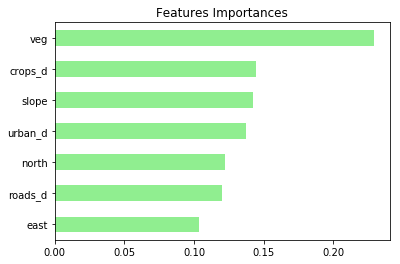

In [121]:
                       
# Import mean_squared_error from sklearn.metrics as MSE 
from sklearn.metrics import mean_squared_error as MSE

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

# Create a pd.Series of features importances
importances = pd.Series(data=best_model.feature_importances_,
                        index=variables) # add the name of the features, maybe it is in the form data.columns?

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()